## IDF based Transformer Embedding Aggregation from word to sentence level for MultiLabel Text Classification

### Introduction

In this notebook, we will develop sentence level embedding based on Huggingface Transformers BERT pre-trained model. We will provide two types of aggregation methods from word level to sentence level, one by regular averaging, the other by weighted average by IDF scores for each token.
We also generate a set of embeddings using Wiki Plot Movie datasets, and a demo with multiclass classification example.


#### Flow of the notebook

The notebook has the following sections:

1. [Importing Python Libraries](#section01)
2. [Defining modules](#section02)
3. [Loading and processing the Dataset](#section03)
4. [Generating sentence level embedding: two sets with diff agg methods](#section04)
5. [Building Classification Models](#section05)
6. [Comparing Classification Models](#section06)

#### Flow of IDF weighted Average for pre-trained Huggingface BERT sentence embedding
<img src="./imgs/flow.png">

## 1. Importing Python Libraries

In [136]:
os.listdir('./imgs')

['flow.png']

In [92]:
import os
import functools

import numpy as np
import pandas as pd
import os, json, gc, re, random
from collections import defaultdict, Counter
import copy
import pickle
from time import time
import math

from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn import metrics

from transformers import RobertaTokenizer, RobertaModel

import torch
# from torch.utils.data import Dataset
# from torch import nn
# from torch.nn import functional as F

import spacy
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## 2. Defining modules

In [12]:
def processWikiPlotData(df):
    
    proc_df = df[(df["Origin/Ethnicity"]=="American") | (df["Origin/Ethnicity"]=="British")]
    proc_df = proc_df[["Plot", "Genre"]]
    drop_indices = proc_df[proc_df["Genre"] == "unknown" ].index
    proc_df.drop(drop_indices, inplace=True)
    # Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
    proc_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

    # Choosing movie genres based on their frequency
    shortlisted_genres = proc_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["index"].tolist()
    proc_df = proc_df[proc_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

    # Shuffle DataFrame
    proc_df = proc_df.sample(frac=1).reset_index(drop=True)

    label_encoder = LabelEncoder()
    proc_df["genre_encoded"] = label_encoder.fit_transform(proc_df["Genre"].tolist())

    proc_df = proc_df[["Plot", "Genre", "genre_encoded"]]
    return proc_df

def partitionList(sentList, n):
    if n == 0:
        return [sentList[:]]
    chunkSize = int(len(sentList)/n)
    remainder = len(sentList) % n
    currentIndex = 0
    res = []

    for i in range(n):
        if i < remainder:
            res.append(sentList[currentIndex: currentIndex+chunkSize+1])
            currentIndex = currentIndex+chunkSize+1
        else:
            res.append(sentList[currentIndex: currentIndex+chunkSize])
            currentIndex = currentIndex+chunkSize
    return res

def genInputs4preBERT(df, textCol='Plot', labelCol='genre_encoded', chunkSize=1000):
    sentList = []
    labelList = []
    for indx, row in df.iterrows():
        sentList.append(row[textCol])
        labelList.append(row[labelCol])
    return sentList, partitionList(sentList, int(len(sentList)/chunkSize)), labelList

def flatenListOfLists(ListOfLists, NumIters=3):
    """
    Flatten the list of list by two stage to guarantee performance on databricks
    :param ListOfLists: Input
    :param NumIters: number of iterations, exponential growing on chunk size
    :return:
    """
    if NumIters <= 0:
        raise ValueError('Iteration number should be at least 1')
    chunkSize = int(len(ListOfLists) ** (1/NumIters)) + 1
    print ('Chunk size={}'.format(chunkSize))
    currList = copy.deepcopy(ListOfLists)

    for _ in range(NumIters-1):
        tempList = []
        loc = 0
        print ('Current length of the list={}'.format(len(currList)))
        while loc < len(currList):
            tempList.append(list(functools.reduce(lambda a, b: a+b, currList[loc:loc+chunkSize])))
            loc += chunkSize
        currList = copy.deepcopy(tempList)

    return list(functools.reduce(lambda a, b: a+b, currList))

In [3]:
def genIdfDict4BERTToks(tokenizer, sentList, saveObj = True):
    """
    Map from BERT token to IDF score
        - IDF scores by Sklearn
    Create a dictionary mapping each token in the text corpus
        to the idf score 
    :return:
    """
    # Get a dictionary of desired token to its IDF score
    idfDict = defaultdict(float)

    tokensList = list(map(lambda line: " ".join(tokenizer.tokenize(line, tokens = tokenizer.tokenize(sentence, do_lower_case=False))), sentList))
    tokenSet = set(flatenListOfLists(tokensList))    
  
    tfIdfVectorizer = TfidfVectorizer(stop_words=None, use_idf=True)
    T = tfIdfVectorizer.fit_transform(tokensList)
    tfidf_features = tfIdfVectorizer.get_feature_names()

    # Get a dictionary of desired token to its IDF score
    idfDict = defaultdict(float)
    start = time()
    L = len(tokensList)
    print ('tokSet count={}'.format(L))
    for i, toks in enumerate(tokensList):
        if i % 500 == 0:
            print ('Indx={} in {}s out of {}'.format(i, time() - start, L))

        tokCounter = Counter(toks.split(' '))
        #print(tokCounter)
        
        numValids = np.sum([tokCounter[tok] for tok in tokCounter if tok in tfidf_features])
        for tok in tokCounter:
            c = tokCounter[tok]
            #print (c)
            if tok in idfDict or c == 0:
                continue

            #print(tok)
            try:
                currIDF = T[i, tfidf_features.index(tok)] * numValids / c
                idfDict[tok] = currIDF
            except:
                pass
            
    if saveObj:
        fName = "./dicts/idfDict.pkl"
        with open(fName, 'wb') as f:
            pickle.dump(
                idfDict,
                f, pickle.HIGHEST_PROTOCOL)
        
    return idfDict

In [13]:
def aggHFTembByMaskV2(embeddings, masks):
    """
    Function to aggregate word embedding to sentence embedding
        for Hugging Face Transformer
    :param embeddings: Embedding tensors, multi dimension(word-level) for
        each sentence
    :param masks: mask tensors
    :return:
    """
    embeddings = embeddings.to('cpu').numpy()
    masks = masks.to('cpu').numpy()
    print(list(zip(embeddings, masks))[0][0].shape)
    #print(list(zip(embeddings, masks))[0])

    maskedVectors = [e[1:np.sum(m)-1] for e, m in zip(embeddings, masks)]

    #print([(len(x), len(x[0])) for x in maskedVectors])
    return [np.mean(vecs, axis=0) for vecs in maskedVectors]

def aggHFTembByIDF(embeddings, weights):
    """
    Function to aggregate word embedding to sentence embedding
        for Hugging Face Transformer
    :param embeddings: Embedding tensors, multi dimension(word-level) for
        each sentence
    :param masks: mask tensors
    :return:
    """
    #print (weights)
    embeddings = embeddings.to('cpu').numpy()
    #print (embeddings.shape, np.array(weights).shape)
    maskedVectors = [(e, m) for e, m in zip(embeddings, np.array(weights))]
    #print([(len(x), len(x[0])) for x in maskedVectors])

    return [np.average(vecs, axis=0, weights=weights) for vecs, weights in maskedVectors]

def encodeHFTwWeightByIDF(
        tokenizer, model, sentences, idfDict, batch_size=512, maxLen=512,
        show_progress_bar=None, device=torch.device('cuda'),
        is_parallel=True):
    """
    Pretraine HFT BERT embedding
    Agg BERT embedding from token level to sentence level
        - Regular average vector and weighted average by token IDF scores
    Computes sentence embeddings based on pretrained BERT model:
        tokenize with max length
        Default model is roBERTa base
    :param tokenizer:
       Hugging Face tokenizer
    :param model:
       Hugging Face model
    :param sentences:
       the sentences to embed
    :param batch_size:
       batch_size for embedding
    :param maxLen:
       max Sentence length including [CLS] [SEP]
    :param batch_size:
       the batch size used for the computation
    :param show_progress_bar:
        Output a progress bar when encode sentences
    :param device:
       GPU or CPU
    :param is_parallel:
       GPU required for is_parallel==True
    :return:
       a list with ndarrays of the embeddings for each sentence
    """

    model.to(device)
    if show_progress_bar is None:
        show_progress_bar = (
                logging.getLogger().getEffectiveLevel() == logging.INFO or
                logging.getLogger().getEffectiveLevel() == logging.DEBUG)

    all_embeddingsM = []
    all_embeddingsW = []
    length_sorted_idx = np.argsort([len(sen.split()) for sen in sentences])

    iterator = range(0, len(sentences), batch_size)
    if show_progress_bar:
        iterator = tqdm(iterator, desc="Batches")

    tok_cnt = 0

    for batch_idx in iterator:
        batch_tokens = []
        batch_masks = []
        batch_weights = []

        batch_start = batch_idx
        batch_end = min(batch_start + batch_size, len(sentences))
        #print ("Batch End", batch_end)
        longest_seq = 0

        # Get the maximal token length
        for idx in length_sorted_idx[batch_start: batch_end]:
            sentence = sentences[idx]
            try:
                tempTK = tokenizer.encode(sentence)
                tempLen = len(tempTK)
            except:
                tempLen = maxLen
            longest_seq = np.max([longest_seq, tempLen])

        maxLen4Batch = np.min([longest_seq, maxLen])
        for idx in length_sorted_idx[batch_start: batch_end]:
            sentence = sentences[idx]
            tokens = tokenizer.tokenize(sentence, do_lower_case=False)
            tokens = ['[CLS]'] + tokens[:maxLen4Batch-2] + ['[SEP]']
            padded_tokens = tokens + [
                '[PAD]' for _ in range(maxLen4Batch - len(tokens))]
            # Get attention masks for each sentence
            specialToks = ['[CLS]', '[SEP]', '[PAD]']
            attn_mask = [
                1 if token not in specialToks
                else 0
                for token in padded_tokens]

            attn_weights = [0 for _ in range(len(attn_mask))]

            for i, tok in enumerate(padded_tokens):
                if attn_mask[i] == 1:
                    attn_weights[i] = idfDict[tok]

                    #print (padded_tokens)
            #print (attn_weights)

            sumWeights = np.sum(attn_weights)
            if sumWeights == 0:
                attn_weights = [1 for _ in range(len(attn_weights))]
            attn_weights = [x/sumWeights for x in attn_weights]

            # Get BERT vocabulary index for each token
            token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

            batch_tokens.append(token_ids)
            batch_masks.append(attn_mask)
            batch_weights.append(attn_weights)

        tok_cnt += len(batch_tokens)
        batch_tokens = torch.tensor(batch_tokens).to(device)
        batch_masks = torch.tensor(batch_masks).to(device)

        if len(batch_weights) == 0:
            continue
        with torch.no_grad():
            #Feed to pretrained BERT model for embedding
            embeddings = torch.nn.parallel.data_parallel(
                model, batch_tokens,
                module_kwargs={'attention_mask': batch_masks})[0] \
                if is_parallel \
                else model.forward(
                batch_tokens, attention_mask=batch_masks)[0]

            # Regular Avg: input torch tensors; output list of vectors
            embeddingsM = aggHFTembByMaskV2(embeddings, batch_masks)

            # Weighted Avg: input torch tensors; output list of vectors
            embeddingsW = aggHFTembByIDF(embeddings, batch_weights)

            #print(batch_tokens.size, len(embeddingsM))
            all_embeddingsW.extend(embeddingsW)
            all_embeddingsM.extend(embeddingsM)
        
        #print (tok_cnt, len(all_embeddingsW))

    print ("Len all_embeddingsW = {}, Len all_embeddingsM  = {}, Len reverting_order = {}"
           .format(len(all_embeddingsW), len(all_embeddingsM), len(length_sorted_idx)))
    reverting_order = np.argsort(length_sorted_idx)
    all_embeddingsW = [all_embeddingsW[idx] for idx in reverting_order]
    all_embeddingsM = [all_embeddingsM[idx] for idx in reverting_order]

    return all_embeddingsM, all_embeddingsW

def UnitVect(vect):
    """
    Normalize to Unit Vector
    :param vect: The vector to normalize
    :return: normalized vector with length 1
    """
    #
    mag = np.linalg.norm(vect)

    # Make sure we don't divide by zero!
    if mag > 0:
        return vect/mag
    elif np.sum(vect) == 0:
        return vect
    elif math.isnan(mag):
        #print(vect)
        return None
    else:
        return None

In [94]:
# Train he LGB model
def trainLGB(df, 
             xCol="norm_embs_mean", 
             yCol="labels",
             RANDOM_STATE = 99,
             num_class = 16,
             learning_rate = 0.01,
             num_leaves = 15,
             min_data_in_leaf = 200,
             feature_fraction = 0.6,
             bagging_fraction = 0.9,
             num_boost_round = 2000,
             max_depth = 9,
             bagging_freq = 7,
             early_stopping_rounds = 30):
    
    # train ligthGBM model
    params = {
          "objective" : "multiclass",
          "num_class" : num_class,
          "num_leaves" : num_leaves,
          "max_depth": max_depth,
          "learning_rate" : learning_rate,
          "bagging_fraction" : bagging_fraction,  # subsample
          "feature_fraction" : feature_fraction,  # colsample_bytree
          "bagging_freq" : bagging_freq,        # subsample_freq
          "bagging_seed" : RANDOM_STATE,
          "verbosity" : -1 }
    
    X = featureDFedt[xCol].tolist()
    l = featureDFedt["labels"].tolist()
    X_train, X_validate, label_train, label_validate = train_test_split(X, l, test_size=0.25, random_state=RANDOM_STATE)
    
    # transform the training dataset for oversampling
    oversample = SMOTE()
    X, y = oversample.fit_resample(X_train, label_train)
    
    dtrain = lgbm.Dataset(np.array([list(v) for v in X]), y)
    dvalid = lgbm.Dataset(np.array([list(v) for v in X_validate]), label_validate, reference=dtrain)
    
    lgbM = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, verbose_eval=25,
                            early_stopping_rounds=early_stopping_rounds)
    
    cm = confusion_matrix(label_validate, [np.argmax(cy) for cy in lgbM.predict(X_validate)])
    #print(cm)
    
    return lgbM, cm

In [100]:
# Evaluate he LGB model
def evalLGB(df,
             xCol,
            lgbM,
           RANDOM_STATE = 2021):
    
    X = featureDFedt[xCol].tolist()
    l = featureDFedt["labels"].tolist()
    X_train, X_validate, label_train, label_validate = train_test_split(X, l, test_size=0.25, random_state=RANDOM_STATE)
    
    y_pred = [np.argmax(cy) for cy in lgbM.predict(X_validate)]
    #print(cm)
    rep = metrics.classification_report(label_validate, y_pred, digits=3)
    return rep

## 3. Loading and processing the Dataset

In [16]:
# Wiki Movie Plot dataset from "https://www.kaggle.com/jrobischon/wikipedia-movie-plots"
# Load dataframe
fPath = './data/wiki_movie_plots_deduped.csv copy.zip'
df = pd.read_csv(fPath)

In [17]:
# Process Data
movies_df = processWikiPlotData(df)

In [120]:
movies_df['genre_encoded'].unique()

array([ 6,  8,  4, 12, 14, 15, 10,  0,  3,  9, 11,  2,  1, 13,  5,  7])

In [123]:
# label to genre dict
label2GenreDict = {}
tL = len(list(movies_df['genre_encoded'].unique()))
for idx, row in movies_df.iterrows():
    curg = row["Genre"]
    curL = row["genre_encoded"]
    label2GenreDict[curL] = curg
    if len(label2GenreDict) == tL:
        break
label2GenreDict

{6: 'drama',
 8: 'horror',
 4: 'crime',
 12: 'science fiction',
 14: 'war',
 15: 'western',
 10: 'mystery',
 0: 'action',
 3: 'comedy',
 9: 'musical',
 11: 'romance',
 2: 'animation',
 1: 'adventure',
 13: 'thriller',
 5: 'crime drama',
 7: 'film noir'}

In [18]:
# Creat inputs for pre-trained BERT encoder
sentList, chunks, labels = genInputs4preBERT(movies_df, chunkSize=1000)

## 4. Generating sentence level embedding: two sets with diff agg methods


In [21]:
# Load roBERTa tokens and model
# Initial tokenizer and model
modelType = 'roberta-base'
print('Loading tokenizer')
tokenizer = RobertaTokenizer.from_pretrained(modelType)
print('Loading pretrained model')
model = RobertaModel.from_pretrained(modelType)

Loading tokenizer
Loading pretrained model


In [ ]:
# Generate token based IDF scores
idfDict = genIdfDict4BERTToks(tokenizer, sentList, saveObj = True)

In [22]:
fName = './dicts/idfDict.pkl'
with open(fName, 'rb') as f:
    idfDict = pickle.load(f)

In [ ]:
# Generate the Aggregated sentence embedding and save by chunk
# Mean and Weighted Avg by IDF scores
for i in range(len(chunks)):
    fName = "./embs/roBERTa_embs_part{}.pkl".format(i+1)
    curEmbs = encodeHFTwWeightByIDF(
        tokenizer, model, chunks[i], idfDict, batch_size=64, maxLen=512,
        show_progress_bar=None, device=torch.device('cpu'),
        is_parallel=False)
    print ("Dump part {} to {}".format(i+1, fName))
    with open(fName, 'wb') as f:
        pickle.dump(
            curEmbs,
            f, pickle.HIGHEST_PROTOCOL)

In [23]:
# Load embedding and merge to labels
rawEmbsMean = []
rawEmbsIdfW = []

for i in range(len(chunks)):
    fName = "./embs/roBERTa_embs_part{}.pkl".format(i+1)

    print ("Load part {} from {}".format(i+1, fName))
    with open(fName, 'rb') as f:
        currEmbs = pickle.load(f)
        
    rawEmbsMean.extend(currEmbs[0])
    rawEmbsIdfW.extend(currEmbs[1])
    
# Check sizes
print (len(rawEmbsMean), len(rawEmbsIdfW), len(labels))

Load part 1 from ./embs/roBERTa_embs_part1.pkl
Load part 2 from ./embs/roBERTa_embs_part2.pkl
Load part 3 from ./embs/roBERTa_embs_part3.pkl
Load part 4 from ./embs/roBERTa_embs_part4.pkl
Load part 5 from ./embs/roBERTa_embs_part5.pkl
Load part 6 from ./embs/roBERTa_embs_part6.pkl
Load part 7 from ./embs/roBERTa_embs_part7.pkl
Load part 8 from ./embs/roBERTa_embs_part8.pkl
Load part 9 from ./embs/roBERTa_embs_part9.pkl
Load part 10 from ./embs/roBERTa_embs_part10.pkl
Load part 11 from ./embs/roBERTa_embs_part11.pkl
Load part 12 from ./embs/roBERTa_embs_part12.pkl
Load part 13 from ./embs/roBERTa_embs_part13.pkl
Load part 14 from ./embs/roBERTa_embs_part14.pkl
Load part 15 from ./embs/roBERTa_embs_part15.pkl
15192 15192 15192


In [24]:
# Build DF and normalize the embeddings
cols = ["raw_embs_mean", "raw_embs_idfw", "labels"]
embDicts = {}
for i, col in enumerate(cols):
    embDicts[col] = [rawEmbsMean, rawEmbsIdfW, labels][i]
featureDF = pd.DataFrame(embDicts)
featureDF["norm_embs_mean"] = featureDF["raw_embs_mean"].apply(UnitVect)
featureDF["norm_embs_idfw"] = featureDF["raw_embs_idfw"].apply(UnitVect)

# Drop rows with nan in case
featureDFedt = featureDF.dropna()

## 5. Building Classification Models

In [75]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [74]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


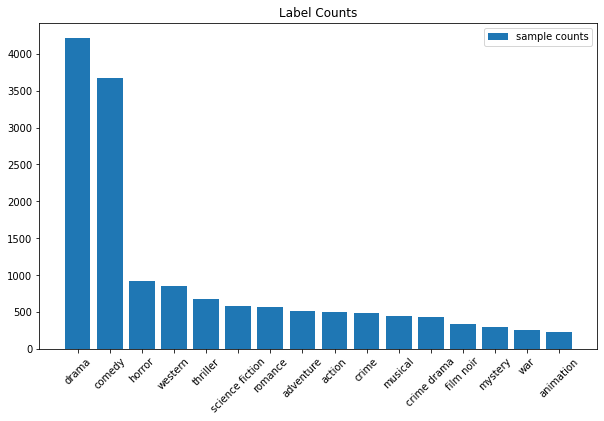

In [135]:
# Imbalanced data
plt.figure(figsize=(10,6))
cts = featureDFedt['labels'].value_counts()
x_value = [label2GenreDict[cl] for cl in cts.keys()]
y_value = cts.values
plt.title('Label Counts')
plt.xticks(rotation = 45)
plt.bar(x_value,y_value, label='sample counts') 
plt.legend()

In [115]:
type(cts)

pandas.core.series.Series

In [38]:
featureDFedt.head()

,raw_embs_mean,raw_embs_idfw,labels,norm_embs_mean,norm_embs_idfw
0,"[0.02154252, 0.11547888, 0.0057376195, -0.1626...","[0.03090267432090993, 0.17266593380477255, -0....",6,"[0.0018537773, 0.009937191, 0.00049373374, -0....","[0.0027959669420421166, 0.015622215667215474, ..."
1,"[0.042925723, 0.15544622, -0.024269631, -0.055...","[0.03744219678006476, 0.20829259954964385, -0....",6,"[0.0036439227, 0.013195678, -0.0020602255, -0....","[0.0036025583103554406, 0.020041191490469207, ..."
2,"[0.031127831, 0.08727137, 0.0095834015, -0.071...","[-0.006864594470996933, 0.11324549126897607, -...",8,"[0.0026951316, 0.0075561902, 0.0008297567, -0....","[-0.0006629951757092065, 0.010937458097396727,..."
3,"[0.013757537, 0.08381358, 0.04083967, -0.06534...","[-0.0077409092613638765, 0.14388482091298502, ...",4,"[0.0012161772, 0.0074091866, 0.0036102592, -0....","[-0.0007445580384305126, 0.013839536984835072,..."
4,"[0.027874012, 0.13634484, -0.03355529, -0.1006...","[-0.0033498941571190985, 0.1748613285128432, -...",8,"[0.002370487, 0.011595162, -0.0028536397, -0.0...","[-0.00031487784583386625, 0.016436327794046936..."


In [80]:
embCols = ["norm_embs_mean", "norm_embs_idfw"]
lgbmModels = []
cms = []
for col in embCols:
    print ('Training lighGBM model with feature {}'.format(col))
    currModel, cm = trainLGB(featureDFedt, 
             xCol = col, 
             yCol="labels",
             RANDOM_STATE = 2021,
             num_class = 16,
             learning_rate = 0.01,
             num_leaves = 35,
             min_data_in_leaf = 15,
             feature_fraction = 0.9,
             bagging_fraction = 0.9,
             num_boost_round = 1000,
             max_depth = 13,
             bagging_freq = 5,
             early_stopping_rounds = 20)
    
    lgbmModels.append(currModel)
    cms.append(cm)
    

Training lighGBM model with feature norm_embs_mean
Training until validation scores don't improve for 20 rounds
[25]	valid_0's multi_logloss: 2.74039
[50]	valid_0's multi_logloss: 2.71338
[75]	valid_0's multi_logloss: 2.68935
[100]	valid_0's multi_logloss: 2.66462
[125]	valid_0's multi_logloss: 2.64366
[150]	valid_0's multi_logloss: 2.6228
[175]	valid_0's multi_logloss: 2.60541
[200]	valid_0's multi_logloss: 2.58722
[225]	valid_0's multi_logloss: 2.5705
[250]	valid_0's multi_logloss: 2.55461
[275]	valid_0's multi_logloss: 2.54018
[300]	valid_0's multi_logloss: 2.52731
[325]	valid_0's multi_logloss: 2.51491
[350]	valid_0's multi_logloss: 2.50396
[375]	valid_0's multi_logloss: 2.49462
[400]	valid_0's multi_logloss: 2.48591
[425]	valid_0's multi_logloss: 2.47713
[450]	valid_0's multi_logloss: 2.4701
[475]	valid_0's multi_logloss: 2.46455
[500]	valid_0's multi_logloss: 2.45819
[525]	valid_0's multi_logloss: 2.45442
[550]	valid_0's multi_logloss: 2.45045
[575]	valid_0's multi_logloss: 2.447

## 6. Compare Classification Models

In [129]:
logsVecMean = [2.74039, 2.71338, 2.68935, 2.66462, 2.64366, 
         2.6228, 2.60541, 2.58722, 2.5705, 2.55461, 
         2.54018, 2.52731, 2.51491, 2.50396, 2.49462, 
         2.47713, 2.4701, 2.46455, 2.45819, 2.45442,
        2.45045, 2.44794, 2.44542, 2.44439, 2.44445]
logsVecIDFW = [2.7328, 2.69981, 2.67199, 2.6472, 2.62563, 
        2.60585, 2.58796, 2.57087, 2.55448, 2.53877,
        2.52476, 2.51128, 2.49864, 2.48786, 2.47809,
        2.46887, 2.46106, 2.45363, 2.44683, 2.44093,
        2.4355, 2.43159, 2.42827, 2.42622, 2.42395,
        2.42203, 2.42084, 2.42055]
x_value = [i*25 for i in range(len(logsVecIDFW))]

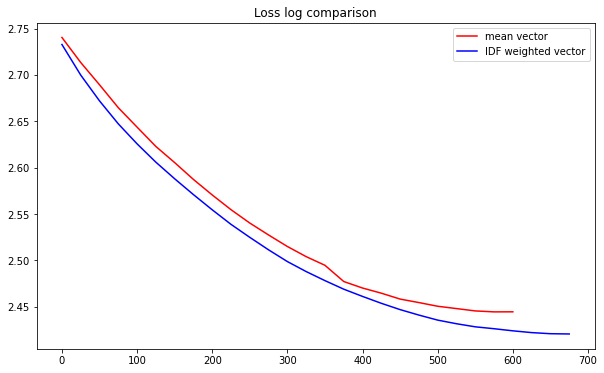

In [131]:
plt.figure(figsize=(10,6))
plt.title('Loss log comparison')
plt.plot(x_value[:len(logsVecMean)],logsVecMean, c='red', label='mean vector') 
plt.plot(x_value,logsVecIDFW, c='blue', label='IDF weighted vector')
plt.legend()

In [97]:
lgbmModels

['norm_embs_idfw',

In [101]:
reps = []
shift = 1
for i, col in enumerate(embCols):
    curLGB = lgbmModels[i+shift]
    curRep = evalLGB(featureDFedt,
             col,
             curLGB)
    reps.append(curRep)

In [110]:
scores = pd.DataFrame({'wavg_precision':[0.152, 0.168], 'wavg_recall':[0.235, 0.246], 'wavg_f1':[0.178, 0.187]}, index=['mean_vector', 'IDFweighted_vector'])
scores

,wavg_precision,wavg_recall,wavg_f1
mean_vector,0.152,0.235,0.178
IDFweighted_vector,0.168,0.246,0.187


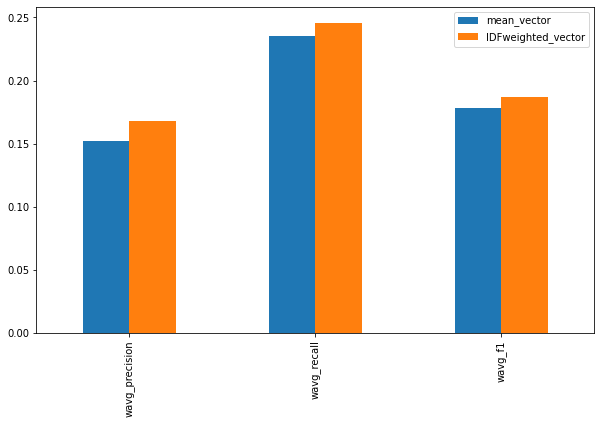

In [133]:

scores.T.plot.bar(figsize=(10,6))